In [1]:
!pip install jiwer

In [2]:
from jiwer import *
import os
from pathlib import Path
from google.colab import drive
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ground_truth_df = pd.read_csv('/content/drive/My Drive/Capstone/Data/Common Voices CSVs/common_voices_23_train_with_validated_votes.csv')
ground_truth_df.head()

/tmp/ipython-input-2928880731.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  ground_truth_df = pd.read_csv('/content/drive/My Drive/Capstone/Data/Common Voices CSVs/common_voices_23_train_with_validated_votes.csv')


,Unnamed: 0,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,36,d0936078bd54b9d7f9c013ff0336b116d8e4a6bcbdcb30...,common_voice_en_27029287.mp3,a0b64e30cde43066bdf9ece96c37e6e7c82020fc1f25ad...,"His father, an immigrant from Russian Poland, ...",NaN,2,0,twenties,female_feminine,NaN,NaN,en,NaN
1,37,d0936078bd54b9d7f9c013ff0336b116d8e4a6bcbdcb30...,common_voice_en_27029289.mp3,a0ba739202f9a3ab1c4d77150d4cd4a2491becb3ce4b42...,The album was well received by critics and was...,NaN,2,0,twenties,female_feminine,NaN,NaN,en,NaN
2,40,d0ca485199855ca4a2281b9ff285c7bc4ba6b25b07c180...,common_voice_en_17761313.mp3,f50a164d3d4990c23b37e119c841e15c8928bb6d5aaa77...,I serve the motto of the Prince of Wales.,NaN,2,0,fourties,male_masculine,NaN,NaN,en,NaN
3,46,d0e828a94294fafae049a30e1f2d3e84aaece28acbe368...,common_voice_en_557492.mp3,e3e0bdc86fca599b1f73be98793cbec5622b392c69bb8b...,It won't do you any harm.,NaN,2,0,twenties,male_masculine,United States English,NaN,en,NaN
4,82,d1962ff8afff858ef5c6e4c2d9d35fcc99b53e8272e34b...,common_voice_en_18666394.mp3,437f11d97503ba8c91e16e34199bf5d26a6d3b37cbb6e1...,Assuredly I would have refused.,NaN,2,0,twenties,male_masculine,United States English,NaN,en,NaN


In [4]:
base_transcripts_df = pd.read_csv('/content/drive/My Drive/Capstone/Data/Common Voices CSVs/transcripts_from_prefix_10082025.csv')
base_transcripts_df.head()

,s3_key,filename,transcribed_text,error
0,common_voice/23/cv-corpus-23.0-2025-09-05/en/c...,common_voice_en_18767408.mp3,Henry Brandt was America's foremost composer ...,NaN
1,common_voice/23/cv-corpus-23.0-2025-09-05/en/c...,common_voice_en_22528397.mp3,Devil Ants was the patriarch leader during th...,NaN
2,common_voice/23/cv-corpus-23.0-2025-09-05/en/c...,common_voice_en_41692514.mp3,"Kylian was born in Birmingham, Alabama, Unite...",NaN
3,common_voice/23/cv-corpus-23.0-2025-09-05/en/c...,common_voice_en_20002587.mp3,The mill was flooded to the level of the firs...,NaN
4,common_voice/23/cv-corpus-23.0-2025-09-05/en/c...,common_voice_en_19497595.mp3,A special tax was levied to provide pay in co...,NaN


In [5]:
df_merged = ground_truth_df.merge(base_transcripts_df, left_on='path', right_on='filename', how='inner')
df_merged.head()

,Unnamed: 0,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,s3_key,filename,transcribed_text,error
0,133,d2275471a5593c9b2a633d1725baf31d790d3b1a7bfc7d...,common_voice_en_32801004.mp3,97d4b7fb78fc443f94a277ae6ee13011861398b46aa3ea...,DenG returned to Liberia and studied business ...,NaN,2,0,sixties,male_masculine,NaN,NaN,en,NaN,common_voice/23/cv-corpus-23.0-2025-09-05/en/c...,common_voice_en_32801004.mp3,Then G returned to Liberia and studied busine...,NaN
1,134,d2275471a5593c9b2a633d1725baf31d790d3b1a7bfc7d...,common_voice_en_32801005.mp3,980e8475cfe6d829a12605b3f88737e7f62b8d5ae8df90...,The museum used to be the old Tainan watercour...,NaN,2,0,sixties,male_masculine,NaN,NaN,en,NaN,common_voice/23/cv-corpus-23.0-2025-09-05/en/c...,common_voice_en_32801005.mp3,The museum used to be the old time-and-water ...,NaN
2,135,d2275471a5593c9b2a633d1725baf31d790d3b1a7bfc7d...,common_voice_en_32801006.mp3,98410e2c32e3ceb1774f02f3356fe18eb99941ebb5ecb1...,He was succeeded by Rev.,NaN,2,0,sixties,male_masculine,NaN,NaN,en,NaN,common_voice/23/cv-corpus-23.0-2025-09-05/en/c...,common_voice_en_32801006.mp3,He was succeeded by Rev.,NaN
3,189,d32584f6c43587b80efb24ec2cef7fed5399146b2035b3...,common_voice_en_40124657.mp3,e93e2541ca33e3e8771390c5c1ee06d119edbe257e5975...,Chavalit began his political activity while st...,NaN,2,0,sixties,male_masculine,England English,NaN,en,NaN,common_voice/23/cv-corpus-23.0-2025-09-05/en/c...,common_voice_en_40124657.mp3,Shabbat began his political activity while st...,NaN
4,190,d32584f6c43587b80efb24ec2cef7fed5399146b2035b3...,common_voice_en_40124658.mp3,e97117c439087a919ccf9e3bfed7d00ad269376f1950ca...,Luke Hannigan continues to write music under a...,NaN,2,0,sixties,male_masculine,England English,NaN,en,NaN,common_voice/23/cv-corpus-23.0-2025-09-05/en/c...,common_voice_en_40124658.mp3,Luke Halligan continues to write music under ...,NaN


In [6]:
len(df_merged)

127124

In [7]:
df_merged = df_merged.rename(columns={'transcribed_text': 'model_transcription', 'sentence': 'ground_truth'})

In [8]:
new_df = df_merged[['path','ground_truth','age','model_transcription']].copy()
new_df.head()

,path,ground_truth,age,model_transcription
0,common_voice_en_32801004.mp3,DenG returned to Liberia and studied business ...,sixties,Then G returned to Liberia and studied busine...
1,common_voice_en_32801005.mp3,The museum used to be the old Tainan watercour...,sixties,The museum used to be the old time-and-water ...
2,common_voice_en_32801006.mp3,He was succeeded by Rev.,sixties,He was succeeded by Rev.
3,common_voice_en_40124657.mp3,Chavalit began his political activity while st...,sixties,Shabbat began his political activity while st...
4,common_voice_en_40124658.mp3,Luke Hannigan continues to write music under a...,sixties,Luke Halligan continues to write music under ...


In [9]:
len(new_df)

127124

In [10]:
def normalize_transcription(text):
  if text is None:
    return ""
  text = str(text)

  # unify whitespace
  text = text.replace("\n", " ")

  # prefer speaker correction before removing brackets: "word [: replacement]" -> "replacement"
  text = re.sub(r'\b\w+\s*\[:\s*([^\]]+)\]', r'\1', text)

  # remove remaining bracket annotations: [/], [//], [* ...], [: ...], etc.
  text = re.sub(r'\[[^\]]+\]', ' ', text)

  # remove angle-bracket fragments/retraces: <...>
  text = re.sub(r'<[^>]+>', ' ', text)

  # micro-pause markers: (.), (..), (...)
  text = re.sub(r'\(\.*\)', ' ', text)

  # normalize "(g)" inflection: askin(g) -> asking, dryin(g) -> drying
  text = re.sub(r'([A-Za-z]+)\(g\)', r'\1g', text)

  # remove chat codes: &=..., &-..., &+...
  text = re.sub(r'&[-=+][^\s.]+', ' ', text)

  # drop "+..." fragments and lone +tokens
  text = re.sub(r'\+\S*', ' ', text)

  # colloquial fixes
  text = re.sub(r'\bhafta\b', 'have to', text, flags=re.IGNORECASE)
  text = re.sub(r'\bhadta\b', 'had to', text, flags=re.IGNORECASE)
  text = re.sub(r'\bwanna\b', 'want to', text, flags=re.IGNORECASE)

  # collapse whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  return text


In [11]:
transformation = Compose([
    normalize_transcription,
    RemovePunctuation(),
    ToLowerCase(),
    RemoveMultipleSpaces(),
    ExpandCommonEnglishContractions(),
    Strip()
])

In [12]:
sample_text = """well the girl is telling the boy to get the cookies down but don't tell your mother. and the boy is also falling over off the stool  and the mother is letting the water run out of the sink . and she's dryin(g) dishes .
and basically it's kind of &-uh a distressing scene .
the child <fell and hadta go> [/] fell and hadta go to the hospital ."""

cleaned = transformation(sample_text)
print("Original:")
print(sample_text)
print("\nCleaned:")
print(cleaned)

Original:
well the girl is telling the boy to get the cookies down but don't tell your mother. and the boy is also falling over off the stool  and the mother is letting the water run out of the sink . and she's dryin(g) dishes .
and basically it's kind of &-uh a distressing scene .
the child <fell and hadta go> [/] fell and hadta go to the hospital .

Cleaned:
well the girl is telling the boy to get the cookies down but dont tell your mother and the boy is also falling over off the stool and the mother is letting the water run out of the sink and shes drying dishes and basically its kind of a distressing scene the child fell and had to go to the hospital


In [13]:
df = new_df.copy()
df["gt_clean"]  = df["ground_truth"].fillna("").astype(str).map(transformation)
df["mod_clean"] = df["model_transcription"].fillna("").astype(str).map(transformation)

In [14]:
df

,path,ground_truth,age,model_transcription,gt_clean,mod_clean
0,common_voice_en_32801004.mp3,DenG returned to Liberia and studied business ...,sixties,Then G returned to Liberia and studied busine...,deng returned to liberia and studied business ...,then g returned to liberia and studied busines...
1,common_voice_en_32801005.mp3,The museum used to be the old Tainan watercour...,sixties,The museum used to be the old time-and-water ...,the museum used to be the old tainan watercour...,the museum used to be the old timeandwater cou...
2,common_voice_en_32801006.mp3,He was succeeded by Rev.,sixties,He was succeeded by Rev.,he was succeeded by rev,he was succeeded by rev
3,common_voice_en_40124657.mp3,Chavalit began his political activity while st...,sixties,Shabbat began his political activity while st...,chavalit began his political activity while st...,shabbat began his political activity while sti...
4,common_voice_en_40124658.mp3,Luke Hannigan continues to write music under a...,sixties,Luke Halligan continues to write music under ...,luke hannigan continues to write music under a...,luke halligan continues to write music under a...
...,...,...,...,...,...,...
127119,common_voice_en_40166302.mp3,"At first, the factory was governed by the Sovi...",fifties,"At first, the factory was governed by the Sov...",at first the factory was governed by the sovie...,at first the factory was governed by the sovie...
127120,common_voice_en_40166330.mp3,His work focused on the difficult lives of the...,fifties,His work focused on the difficult lives of th...,his work focused on the difficult lives of the...,his work focused on the difficult lives of the...
127121,common_voice_en_40183264.mp3,Alvarado worked closely with her husband for t...,fifties,Alvarado worked closely with her husband for ...,alvarado worked closely with her husband for t...,alvarado worked closely with her husband for t...
127122,common_voice_en_40183291.mp3,"His works include SuperLambBanana, a sculpture...",fifties,"His works include SuperLam, Banana, Skabtron,...",his works include superlambbanana a sculpture ...,his works include superlam banana skabtron liv...


In [15]:
def process_dataframe(
    df: pd.DataFrame,
    ref_col: str = "ground_truth",
    hyp_col: str = "model_transcription",
    normalizer=transformation,
    return_corpus: bool = True,
):
    """
    Cleans df[ref_col] and df[hyp_col] with `normalizer`, then computes:
      Word-level: wer, mer, wil, wip, hits, substitutions, deletions, insertions
      Char-level: cer, hits, substitutions, deletions, insertions
    Returns:
      metrics_df (original + *_clean + all metrics), and a corpus_stats dict.
    """
    out = df.copy()

    # normalize text
    out["gt_clean"]  = out[ref_col].fillna("").astype(str).map(normalizer)
    out["hyp_clean"] = out[hyp_col].fillna("").astype(str).map(normalizer)

    # per-row metrics
    records = []
    for g, h in zip(out["gt_clean"], out["hyp_clean"]):
        w = process_words(g, h)         # word-level stats object
        #c = process_characters(g, h)    # char-level stats object
        records.append({
            # word-level
            "wer": w.wer,
            "mer": w.mer,
            "wil": w.wil,
            "wip": w.wip,
            "w_hits": w.hits,
            # "w_substitutions": w.substitutions,
            # "w_deletions": w.deletions,
            # "w_insertions": w.insertions,
            # char-level
            # "cer": c.cer,
            # "c_hits": c.hits,
            # "c_substitutions": c.substitutions,
            # "c_deletions": c.deletions,
            # "c_insertions": c.insertions,
        })

    metrics = pd.DataFrame.from_records(records, index=out.index)
    out = pd.concat([out, metrics], axis=1)

    if not return_corpus:
        return out

    # corpus-level aggregates
    w_corpus = process_words(" ".join(out["gt_clean"]), " ".join(out["hyp_clean"]))
    #c_corpus = process_characters("".join(out["gt_clean"]), "".join(out["hyp_clean"]))
    corpus_stats = {
        # word-level corpus
        "corpus_wer": w_corpus.wer,
        "corpus_mer": w_corpus.mer,
        "corpus_wil": w_corpus.wil,
        "corpus_wip": w_corpus.wip,
        "corpus_w_hits": w_corpus.hits,
        # "corpus_w_substitutions": w_corpus.substitutions,
        # "corpus_w_deletions": w_corpus.deletions,
        # "corpus_w_insertions": w_corpus.insertions,
        # # char-level corpus
        # "corpus_cer": c_corpus.cer,
        # "corpus_c_hits": c_corpus.hits,
        # "corpus_c_substitutions": c_corpus.substitutions,
        # "corpus_c_deletions": c_corpus.deletions,
        # "corpus_c_insertions": c_corpus.insertions,
        #  per-row means
        "row_mean_wer": out["wer"].mean(),
        # "row_mean_cer": out["cer"].mean(),
    }

    return out, corpus_stats


In [16]:
processed_df, corpus = process_dataframe(df)
processed_df.head()         # has gt_clean, mod_clean, and all metrics
print(corpus["corpus_wer"]) # overall WER
print(corpus["corpus_cer"]) # overall CER


0.11859430298624529


KeyError: 'corpus_cer'

In [17]:
processed_df

,path,ground_truth,age,model_transcription,gt_clean,mod_clean,hyp_clean,wer,mer,wil,wip,w_hits
0,common_voice_en_32801004.mp3,DenG returned to Liberia and studied business ...,sixties,Then G returned to Liberia and studied busine...,deng returned to liberia and studied business ...,then g returned to liberia and studied busines...,then g returned to liberia and studied busines...,0.166667,0.153846,0.224359,0.775641,11
1,common_voice_en_32801005.mp3,The museum used to be the old Tainan watercour...,sixties,The museum used to be the old time-and-water ...,the museum used to be the old tainan watercour...,the museum used to be the old timeandwater cou...,the museum used to be the old timeandwater cou...,0.153846,0.153846,0.284024,0.715976,11
2,common_voice_en_32801006.mp3,He was succeeded by Rev.,sixties,He was succeeded by Rev.,he was succeeded by rev,he was succeeded by rev,he was succeeded by rev,0.000000,0.000000,0.000000,1.000000,5
3,common_voice_en_40124657.mp3,Chavalit began his political activity while st...,sixties,Shabbat began his political activity while st...,chavalit began his political activity while st...,shabbat began his political activity while sti...,shabbat began his political activity while sti...,0.090909,0.090909,0.173554,0.826446,10
4,common_voice_en_40124658.mp3,Luke Hannigan continues to write music under a...,sixties,Luke Halligan continues to write music under ...,luke hannigan continues to write music under a...,luke halligan continues to write music under a...,luke halligan continues to write music under a...,0.100000,0.100000,0.190000,0.810000,9
...,...,...,...,...,...,...,...,...,...,...,...,...
127119,common_voice_en_40166302.mp3,"At first, the factory was governed by the Sovi...",fifties,"At first, the factory was governed by the Sov...",at first the factory was governed by the sovie...,at first the factory was governed by the sovie...,at first the factory was governed by the sovie...,0.000000,0.000000,0.000000,1.000000,13
127120,common_voice_en_40166330.mp3,His work focused on the difficult lives of the...,fifties,His work focused on the difficult lives of th...,his work focused on the difficult lives of the...,his work focused on the difficult lives of the...,his work focused on the difficult lives of the...,0.166667,0.153846,0.224359,0.775641,11
127121,common_voice_en_40183264.mp3,Alvarado worked closely with her husband for t...,fifties,Alvarado worked closely with her husband for ...,alvarado worked closely with her husband for t...,alvarado worked closely with her husband for t...,alvarado worked closely with her husband for t...,0.000000,0.000000,0.000000,1.000000,12
127122,common_voice_en_40183291.mp3,"His works include SuperLambBanana, a sculpture...",fifties,"His works include SuperLam, Banana, Skabtron,...",his works include superlambbanana a sculpture ...,his works include superlam banana skabtron liv...,his works include superlam banana skabtron liv...,0.444444,0.444444,0.652778,0.347222,5


In [18]:
def visualize_asr_metrics(processed_df, save_dir="/mnt/data/asr_plots"):

    Path(save_dir).mkdir(parents=True, exist_ok=True)
    saved = []

    def _save_and_show(fig, fname, title=None):
        if title:
            fig.suptitle(title)
        fig.tight_layout()
        fig.savefig(os.path.join(save_dir, fname), dpi=150, bbox_inches="tight")
        plt.show()
        saved.append(os.path.join(save_dir, fname))

    # Histograms
    for col, title in [
        ("wer", "WER Distribution"),
        ("cer", "CER Distribution"),
        ("mer", "MER Distribution"),
        ("wip", "WIP (Word Information Preserved) Distribution"),
        ("wil", "WIL (Word Information Lost) Distribution"),
    ]:
        if col in processed_df.columns:
            fig = plt.figure()
            plt.hist(processed_df[col].dropna(), bins=30)
            plt.xlabel(col.upper()); plt.ylabel("Count"); plt.title(title)
            _save_and_show(fig, f"{col}_hist.png")

    # WER vs CER
    if {"wer","cer"}.issubset(processed_df.columns):
        fig = plt.figure()
        plt.scatter(processed_df["wer"], processed_df["cer"], alpha=0.6)
        plt.xlabel("WER"); plt.ylabel("CER"); plt.title("WER vs CER")
        _save_and_show(fig, "wer_vs_cer_scatter.png")

    # Word-level totals
    w_cols = ["w_hits", "w_substitutions", "w_deletions", "w_insertions"]
    if all(c in processed_df.columns for c in w_cols):
        totals = processed_df[w_cols].sum()
        fig = plt.figure()
        plt.bar(totals.index, totals.values)
        plt.title("Word-level Totals (Hits/Subs/Dels/Ins)")
        plt.xlabel("Word-level Metric"); plt.ylabel("Total Count")
        _save_and_show(fig, "word_level_totals.png")

    # Char-level totals
    c_cols = ["c_hits", "c_substitutions", "c_deletions", "c_insertions"]
    if all(c in processed_df.columns for c in c_cols):
        totals = processed_df[c_cols].sum()
        fig = plt.figure()
        plt.bar(totals.index, totals.values)
        plt.title("Character-level Totals (Hits/Subs/Dels/Ins)")
        plt.xlabel("Character-level Metric"); plt.ylabel("Total Count")
        _save_and_show(fig, "char_level_totals.png")

    # Boxplots
    if "wer" in processed_df.columns:
        fig = plt.figure(); plt.boxplot(processed_df["wer"].dropna(), vert=True, labels=["WER"])
        plt.title("WER Boxplot"); _save_and_show(fig, "wer_boxplot.png")
    if "cer" in processed_df.columns:
        fig = plt.figure(); plt.boxplot(processed_df["cer"].dropna(), vert=True, labels=["CER"])
        plt.title("CER Boxplot"); _save_and_show(fig, "cer_boxplot.png")

    # Top-K error bars
    top_k = min(25, len(processed_df))
    if top_k and all(c in processed_df.columns for c in w_cols):
        df_top = processed_df.nlargest(top_k, "wer")[w_cols]
        totals_per_utt = (df_top["w_substitutions"] + df_top["w_deletions"] + df_top["w_insertions"])
        fig = plt.figure()
        plt.bar(range(len(totals_per_utt)), totals_per_utt.values)
        plt.title(f"Top {top_k} Utterances by WER — Word Errors per Utterance")
        plt.xlabel("Utterance Index (Top-K by WER)"); plt.ylabel("Word Errors (S + D + I)")
        _save_and_show(fig, "topK_word_errors_per_utterance.png")

    if top_k and all(c in processed_df.columns for c in c_cols):
        df_top = processed_df.nlargest(top_k, "cer")[c_cols]
        totals_per_utt = (df_top["c_substitutions"] + df_top["c_deletions"] + df_top["c_insertions"])
        fig = plt.figure()
        plt.bar(range(len(totals_per_utt)), totals_per_utt.values)
        plt.title(f"Top {top_k} Utterances by CER — Char Errors per Utterance")
        plt.xlabel("Utterance Index (Top-K by CER)"); plt.ylabel("Char Errors (S + D + I)")
        _save_and_show(fig, "topK_char_errors_per_utterance.png")

    return saved


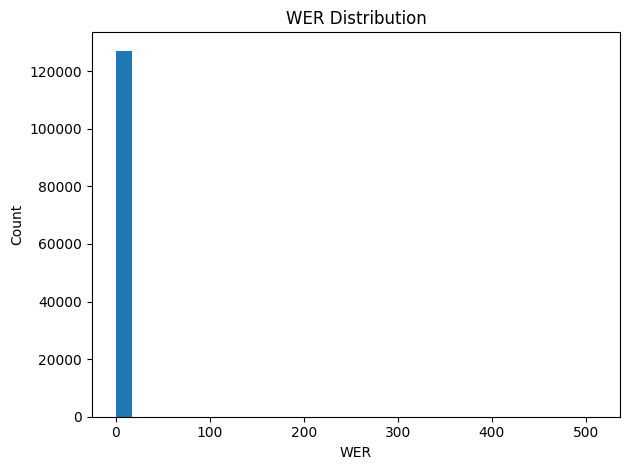

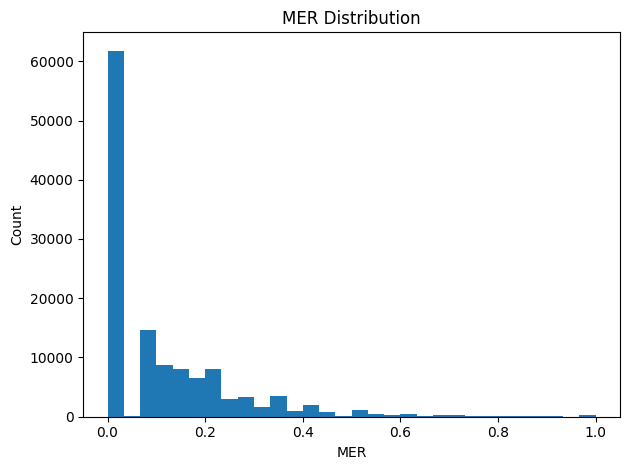

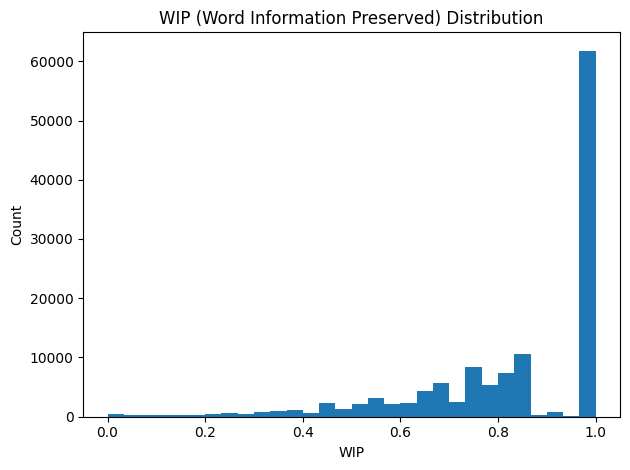

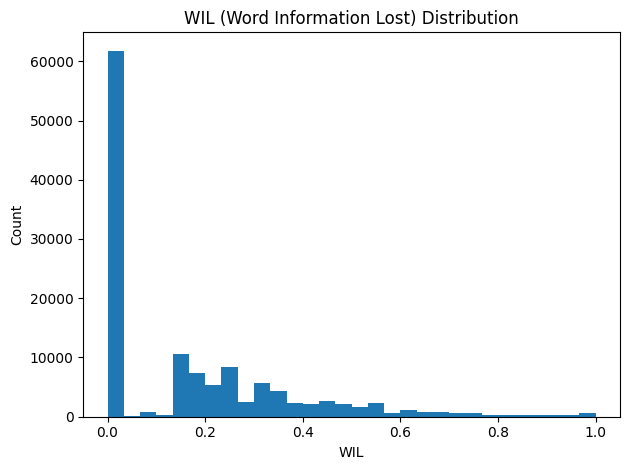

/tmp/ipython-input-2204037792.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  fig = plt.figure(); plt.boxplot(processed_df["wer"].dropna(), vert=True, labels=["WER"])


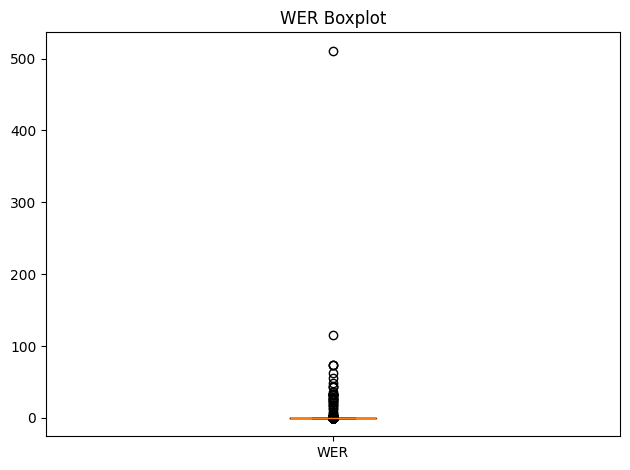

['/mnt/data/asr_plots/wer_hist.png',
 '/mnt/data/asr_plots/mer_hist.png',
 '/mnt/data/asr_plots/wip_hist.png',
 '/mnt/data/asr_plots/wil_hist.png',
 '/mnt/data/asr_plots/wer_boxplot.png']

In [19]:
visualizations = visualize_asr_metrics(processed_df)
visualizations


In [24]:
metrics = ["wer", "mer", "wil", "wip", "w_hits"]

needed = ["age"] + metrics
work = processed_df[needed].copy()

# coerce metrics to numeric
for m in metrics:
    work[m] = pd.to_numeric(work[m], errors="coerce")


# map decades
decade_map = {
    "teens": 15, "teen": 15,
    "twenties": 20, "thirties": 30,
    "forties": 40, "fourties": 40,
    "fifties": 50, "sixties": 60, "seventies": 70,
    "eighties": 80, "nineties": 90,
}
def age_to_num(x):
    s = str(x).strip().lower()
    if s in decade_map:
        return decade_map[s]
    m = re.search(r"\d+", s)
    return int(m.group()) if m else np.nan

work["age_num"] = work["age"].map(age_to_num)

# two buckets: <60 vs >=60
work["age_group"] = np.where(work["age_num"] >= 60, "60_and_above",
                       np.where(work["age_num"].notna(), "below_60", None))

# means + counts
avg = (work.groupby("age_group", dropna=False)[metrics]
           .mean(numeric_only=True)
           .reindex(["below_60", "60_and_above"]))
cnt = work.groupby("age_group", dropna=False).size().rename("n") \
          .reindex(["below_60", "60_and_above"])

summary_2grp = pd.concat([avg, cnt], axis=1).round(4)

print("Averages by age group (mean of each metric) with sample size n:")
display(summary_2grp)

Averages by age group (mean of each metric) with sample size n:


,wer,mer,wil,wip,w_hits,n
age_group,,,,,,
below_60,0.1521,0.124,0.1917,0.8083,9.1166,63562
60_and_above,0.1073,0.091,0.1458,0.8542,9.5636,63562


Averages by numeric age decade with sample size n:


,wer,mer,wil,wip,w_hits,n
age_num,,,,,,
20,0.1788,0.1405,0.2151,0.7849,8.9658,29012
30,0.1262,0.1078,0.1686,0.8314,9.2203,16511
40,0.1549,0.1246,0.1926,0.8074,9.1721,10614
50,0.1012,0.0949,0.1508,0.8492,9.3954,7425
60,0.1079,0.0904,0.1447,0.8553,9.5749,56437
70,0.1012,0.0952,0.1524,0.8476,9.4866,5915
80,0.1021,0.0972,0.1580,0.8420,9.3372,1032
90,0.1296,0.1207,0.1919,0.8081,9.8596,178


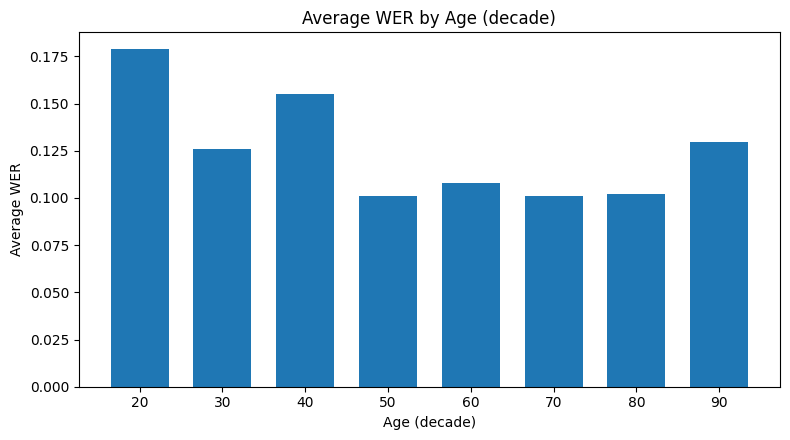

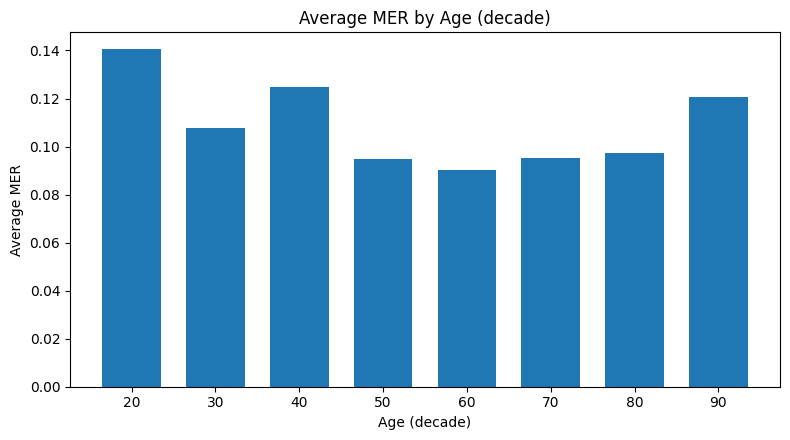

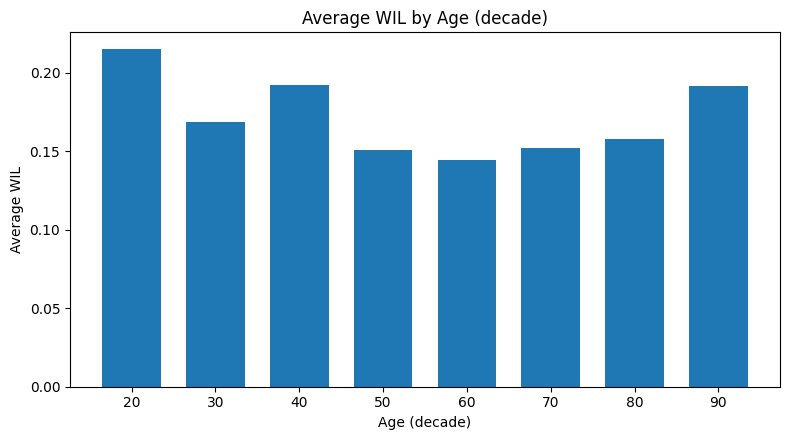

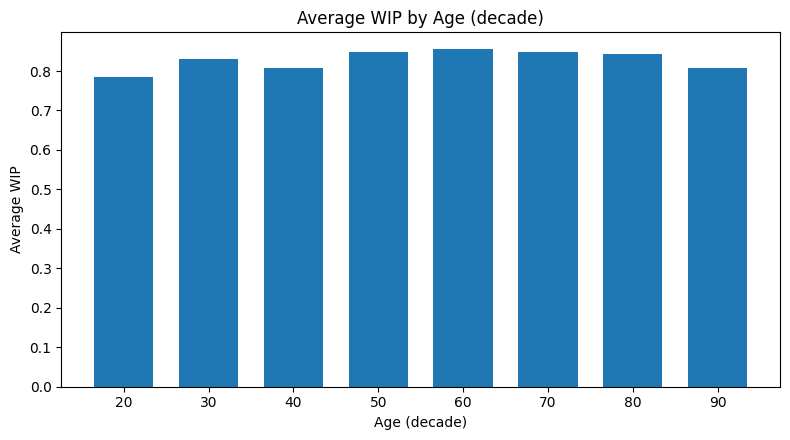

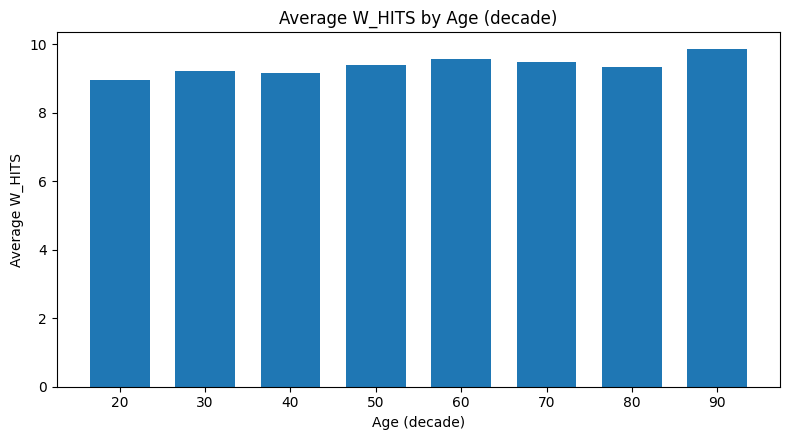

In [32]:
# Order ages numerically ascending
age_order = sorted(work["age_num"].dropna().unique())

#Averages table
avg_by_age = work.groupby("age_num", dropna=False)[metrics].mean().reindex(age_order)
cnt_by_age = work.groupby("age_num", dropna=False).size().rename("n").reindex(age_order)
summary = pd.concat([avg_by_age, cnt_by_age], axis=1).round(4)
decades = avg_by_age.index.astype(int).values
step = np.median(np.diff(decades))
bar_width = 0.7 * step

print("Averages by numeric age decade with sample size n:")
display(summary)

# Charts
for m in metrics:
    plt.figure(figsize=(8, 4.5))
    plt.bar(decades, avg_by_age[m].values, width=bar_width)
    plt.title(f"Average {m.upper()} by Age (decade)")
    plt.xlabel("Age (decade)")
    plt.ylabel(f"Average {m.upper()}")
    plt.xticks(avg_by_age.index.astype(int))
    plt.tight_layout()
    plt.show()


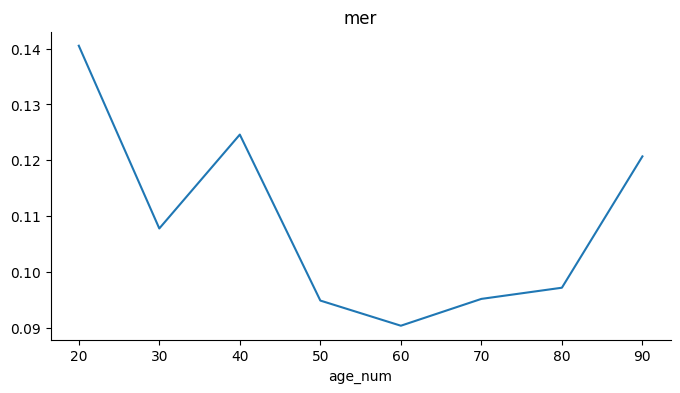

In [28]:
summary['mer'].plot(kind='line', figsize=(8, 4), title='mer')
plt.gca().spines[['top', 'right']].set_visible(False)

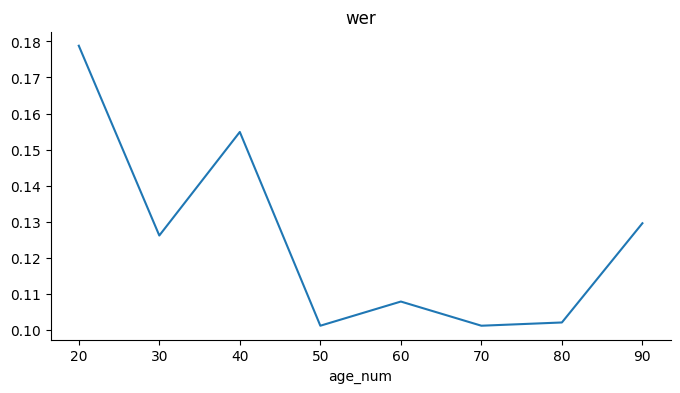

In [27]:
summary['wer'].plot(kind='line', figsize=(8, 4), title='wer')
plt.gca().spines[['top', 'right']].set_visible(False)